## Trabajo Fin de Grado
### Gestor de Quirófanos
### Implementación de Algoritmo Genético para asignación de quirófanos

#### Autor: Jesús García Armario

In [1]:
# Imports necesarios
import numpy as np
import pandas as pd
from deap import base, creator, tools, algorithms
import sys
sys.path.append('../')
from Heuristicas.Utils import Quirofano, ActoQuirurgico, Heuristicas
import random
import math
import matplotlib.pyplot as plt
from utilsGenetico import cromosomaAleatorio, evaluar, distance, validar, cruce, mutacion
import time

In [2]:
# Importamos el listado preprocesado de una especialidad para las pruebas
filename = '..\\..\\Datos\\Listados_Preprocesados\\ListadoInterv_Preprocesado_MAXILOFACIAL.xlsx'
df = pd.read_excel(filename)
# Seleccionamos una muestra aleatoria de 100 pacientes
df = df.sample(n=100, random_state=1)
# Nos quedamos sólo con el NHC, Ponderación y duración
df = df[['NHC', 'PONDERACIÓN', 'DURACIÓN']]
# Sumamos a la duración 25 minutos por paciente para tener en cuenta el tiempo de preparación
df['DURACIÓN'] = df['DURACIÓN'] + 25
ventana = 30
# Dividimos la duración entre la ventana y redondeamos hacia arriba
df['DURACIÓN'] = df['DURACIÓN'].apply(lambda x: math.ceil(x/ventana))
# Creamos un set de actos quirúrgicos
actos_pendientes = list()
i = 0
for elemento in df.itertuples():
    actos_pendientes.append(ActoQuirurgico(i, elemento[3], elemento[1], elemento[2]))
    i += 1

In [3]:
# Definimos al individuo
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register("cromosoma", cromosomaAleatorio, tiempos=16, quirofanos=3, dias=5, actos_pendientes=actos_pendientes)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.cromosoma)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [4]:
toolbox.register("evaluate", evaluar, tiempos=16, quirofanos=3, dias=5, actos_pendientes=actos_pendientes)
toolbox.register("mate", cruce)
toolbox.register("mutate", mutacion)
toolbox.register("select", tools.selTournament, tournsize=3)

In [5]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean) 
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max) 

In [6]:
# Definimos el algoritmo genético
def algoritmo_genetico(poblacion, probabilidad_cruce, probabilidad_mutacion, numero_generaciones):
    # Evaluamos la población
    fitnesses = list(map(toolbox.evaluate, poblacion))
    for ind, fit in zip(poblacion, fitnesses):
        ind.fitness.values = fit
    # Inicializamos las estadísticas
    record = stats.compile(poblacion)
    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + (stats.fields if stats else [])
    # Guardamos las estadísticas
    logbook.record(gen=0, evals=len(poblacion), **record)
    print(logbook.stream)
    # Iniciamos contador de generaciones sin mejora
    contador = 0
    hof = tools.HallOfFame(1)
    hof.update(poblacion)
    # Ejecutamos el algoritmo genético
    for g in range(1, numero_generaciones):
        # Seleccionamos a la población
        poblacion = toolbox.select(poblacion, len(poblacion))
        # Clonamos a los individuos
        hijos = list(map(toolbox.clone, poblacion))
        # Aplicamos el cruce
        for hijo1, hijo2 in zip(hijos[::2], hijos[1::2]):
            if random.random() < probabilidad_cruce:
                toolbox.mate(hijo1, hijo2)
                del hijo1.fitness.values
                del hijo2.fitness.values
        # Aplicamos la mutación
        for hijo in hijos:
            if random.random() < probabilidad_mutacion:
                toolbox.mutate(hijo)
                del hijo.fitness.values
        # Evaluamos a los individuos con fitness inválido
        invalid_ind = [ind for ind in hijos if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        # Reemplazamos a la población
        poblacion[:] = hijos
        # Guardamos las estadísticas
        record = stats.compile(poblacion)
        logbook.record(gen=g, evals=len(poblacion), **record)
        print(logbook.stream)
        # Comprobamos si el mejor individuo ha mejorado
        if hof[0].fitness.values[0] > record['min']:
            contador = 0
        else:
            contador += 1
        hof.update(poblacion)
        # Si no ha mejorado en 50 generaciones, paramos
        if contador == 100:
            break
    return poblacion, logbook, hof

In [7]:
# Contador de tiempo
start_time = time.time()
poblacion = toolbox.population(n=200)
# Cargamos el algoritmo genético
poblacion, logbook, hof = algoritmo_genetico(poblacion, probabilidad_cruce=0.85, probabilidad_mutacion=0.15, numero_generaciones=1000)
final_time = time.time() - start_time

gen	evals	avg 	std    	min	max
0  	200  	3.87	1.71555	1  	9  
1  	200  	2.54	1.21589	1  	6  
2  	200  	1.7 	0.860233	1  	5  
3  	200  	1.235	0.57426 	1  	5  
4  	200  	1.095	0.382067	1  	4  
5  	200  	1.1  	0.412311	1  	4  
6  	200  	1.1  	0.424264	1  	4  
7  	200  	1.09 	0.376696	1  	4  
8  	200  	1.185	0.529882	1  	3  
9  	200  	1.1  	0.412311	1  	3  
10 	200  	1.115	0.414457	1  	3  
11 	200  	1.085	0.31269 	1  	3  
12 	200  	1.08501	0.384378	0.00264068	4  
13 	200  	1.165  	0.527044	1         	4  
14 	200  	1.09   	0.389744	1         	3  
15 	200  	1.105  	0.37944 	1         	3  
16 	200  	1.115  	0.449194	1         	4  
17 	200  	1.095  	0.4074  	1         	4  
18 	200  	1.15   	0.48734 	1         	4  
19 	200  	1.115  	0.46019 	1         	5  
20 	200  	1.115  	0.46019 	1         	4  
21 	200  	1.07   	0.308383	1         	3  
22 	200  	1.11   	0.421782	1         	4  
23 	200  	1.075  	0.330719	1         	3  
24 	200  	1.105  	0.392396	1         	3  
25 	200  	1.17   	0.566657	1    

In [8]:
print("Mejor individuo: ", hof[0])
print("Fitness del mejor: ", hof[0].fitness.values[0])
print("Tiempo de ejecución: ", final_time)

Mejor individuo:  [16, 76, 85, 51, 15, 89, 63, 'A', 26, 81, 56, 21, 'A', 41, 54, 'A', 'B', 29, 27, 11, 25, 0, 'A', 58, 35, 28, 57, 59, 'A', 44, 92, 99, 46, 95, 43, 'V', 90, 'A', 'B', 91, 82, 97, 'A', 40, 72, 8, 14, 73, 'A', 66, 64, 2, 79, 'A', 'B', 78, 5, 37, 'V', 45, 'A', 9, 87, 6, 'A', 42, 30, 19, 88, 83, 'A', 'B', 39, 23, 68, 74, 70, 55, 'A', 80, 38, 22, 52, 53, 18, 'A', 86, 32, 'A', 'B']
Fitness del mejor:  0.002520801098934464
Tiempo de ejecución:  20.117413997650146


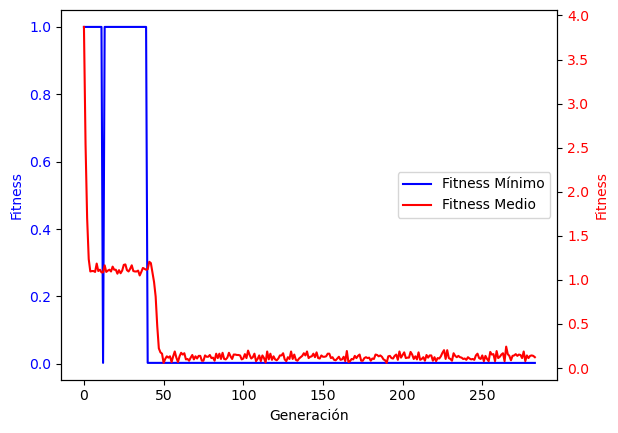

In [9]:
def representaAlgoritmoGenetico(logbook):
    # Representamos el logbook
    gen = logbook.select("gen")
    fit_mins = logbook.select("min")
    fit_maxs = logbook.select("max")
    fit_averages = logbook.select("avg")
    fig, ax1 = plt.subplots()
    line1 = ax1.plot(gen, fit_mins, "b-", label="Fitness Mínimo")
    ax1.set_xlabel("Generación")
    ax1.set_ylabel("Fitness", color="b")
    for tl in ax1.get_yticklabels():
        tl.set_color("b")
    ax2 = ax1.twinx()
    line2 = ax2.plot(gen, fit_averages, "r-", label="Fitness Medio")
    ax2.set_ylabel("Fitness", color="r")
    for tl in ax2.get_yticklabels():
        tl.set_color("r")
    lns = line1 + line2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc="center right")
    plt.show()

representaAlgoritmoGenetico(logbook)

Incluimos las heurísticas como parte de la población inicial

In [10]:
# Función que traduce el fenotipo de la heurística a un cromosoma
def fenotipoACromosoma(fenotipo):
    dias = len(fenotipo)
    quirofanos = len(fenotipo[0])
    cromosoma = []
    for i in range(dias):
        for j in range(quirofanos):
            for acto in fenotipo[i][j].getActos():
                cromosoma.append(acto.getId())
            cromosoma.append('A')
        cromosoma.append('B')
    return cromosoma

modelo_heur = Heuristicas(actos_pendientes, 3, 5, 16)
asignacionLPT, _ = modelo_heur.ejecutaHeuristica()
asignacionLPTEDD, _ = modelo_heur.ejecutaHeuristica("LPTEDD")

In [11]:
toolbox.register("heuristicaLPT", fenotipoACromosoma,asignacionLPT)
toolbox.register("heuristicaLPTEDD", fenotipoACromosoma,asignacionLPTEDD)
toolbox.register("indModelo", tools.initIterate, creator.Individual, toolbox.heuristicaLPT)
toolbox.register("indModeloDos", tools.initIterate, creator.Individual, toolbox.heuristicaLPTEDD)

In [12]:
ind = toolbox.indModelo()

In [15]:
# Creamos un individuo con la heurística LPT
# Iniciamos el contador de tiempo
start_time = time.time()
ind = toolbox.indModelo()
final_time = time.time() - start_time
# Evaluamos el individuo
fitness = toolbox.evaluate(ind)
print("Fitness del individuo con la heurística LPT: ", fitness)
print("Tiempo de ejecución: ", final_time)

Fitness del individuo con la heurística LPT:  (0.004160846001772835,)
Tiempo de ejecución:  0.0


In [16]:
# Creamos un individuo con la heurística LPTEDD
# Iniciamos el contador de tiempo
start_time = time.time()
ind = toolbox.indModeloDos()
final_time = time.time() - start_time
# Evaluamos el individuo
fitness = toolbox.evaluate(ind)
print("Fitness del individuo con la heurística LPT/EDD: ", fitness)
print("Tiempo de ejecución: ", final_time)

Fitness del individuo con la heurística LPT/EDD:  (0.004877853334892653,)
Tiempo de ejecución:  0.0


In [13]:
# Contador de tiempo
start_time = time.time()
# Iniciamos población aleatoria
poblacion = toolbox.population(n=200)
# Sustituimos a dos individuos aleatorios por los individuos de las heurísticas
poblacion[random.randint(0, len(poblacion)-1)] = toolbox.indModelo()
poblacion[random.randint(0, len(poblacion)-1)] = toolbox.indModeloDos()
# Cargamos el algoritmo genético
poblacion, logbook, hof_comb = algoritmo_genetico(poblacion, probabilidad_cruce=0.85, probabilidad_mutacion=0.15, numero_generaciones=1000)
final_time = time.time() - start_time

gen	evals	avg    	std    	min       	max
0  	200  	3.66011	1.62898	0.00209789	8  
1  	200  	2.49028	1.34851	0.00209789	7  
2  	200  	1.47087	1.07077	0.00209789	4  
3  	200  	0.676846	0.822731	0.00209789	3  
4  	200  	0.247527	0.650952	0.00209789	4  
5  	200  	0.152302	0.465629	0.00209789	2  
6  	200  	0.102197	0.359946	0.00209666	2  
7  	200  	0.0871159	0.370696	0.00209666	3  
8  	200  	0.106974 	0.404426	0.00208435	2  
9  	200  	0.141919 	0.489758	0.00207609	3  
10 	200  	0.156876 	0.500394	0.00207208	3  
11 	200  	0.126906 	0.434625	0.00207208	3  
12 	200  	0.116913 	0.401666	0.00207208	2  
13 	200  	0.106939 	0.416615	0.00207065	3  
14 	200  	0.101933 	0.386799	0.00207065	2  
15 	200  	0.106929 	0.404438	0.00206982	2  
16 	200  	0.171834 	0.529601	0.00206388	3  
17 	200  	0.0869269	0.327792	0.00206388	2  
18 	200  	0.111926 	0.455496	0.00206388	3  
19 	200  	0.101936 	0.423808	0.00206388	3  
20 	200  	0.121893 	0.418504	0.00206388	2  
21 	200  	0.22682  	0.650812	0.00206356	3  
22 	

Mejor individuo:  [1, 74, 84, 96, 82, 76, 'V', 0, 'A', 27, 52, 59, 30, 48, 'A', 12, 15, 13, 65, 25, 'A', 'B', 91, 26, 19, 99, 'A', 35, 97, 46, 33, 42, 'A', 40, 34, 86, 79, 'A', 'B', 32, 54, 'A', 75, 49, 61, 14, 'A', 7, 22, 4, 67, 'A', 'B', 29, 85, 37, 89, 31, 'A', 11, 28, 87, 38, 'A', 24, 57, 88, 72, 'A', 'B', 41, 70, 80, 60, 'V', 39, 'A', 53, 92, 51, 69, 95, 18, 63, 'A', 45, 'V', 43, 77, 56, 'A', 'B']
Fitness del mejor:  0.002037620808758102
Tiempo de ejecución:  17.58512234687805


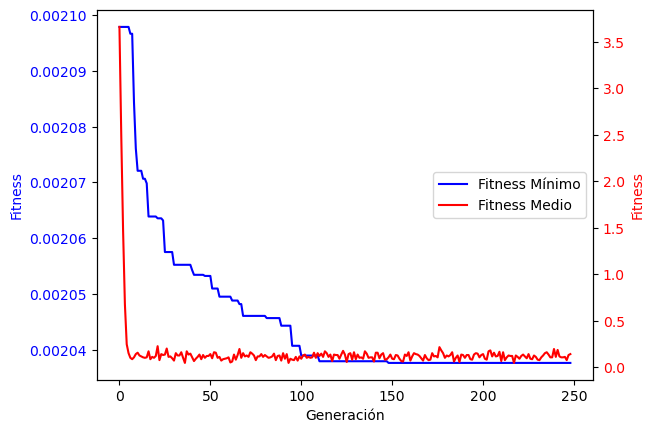

In [14]:
print("Mejor individuo: ", hof_comb[0])
print("Fitness del mejor: ", hof_comb[0].fitness.values[0])
print("Tiempo de ejecución: ", final_time)
representaAlgoritmoGenetico(logbook)

Fitness LPT:  0.004467990343310853
Fitness LPTEDD:  0.004877853334892653
Fitness Combinado:  0.002598424209668574
Fitness Genético:  0.0026698868012951273


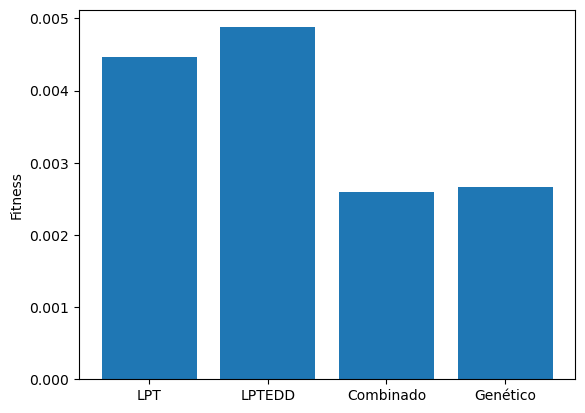

In [15]:
# Se representan los fitness de los mejores individuos
mejor_LPT = toolbox.indModelo()
mejor_LPTEDD = toolbox.indModeloDos()
mejor_comb = hof_comb[0]
mejor_gene = hof[0]

# Se evalúan
mejor_LPT.fitness.values = toolbox.evaluate(mejor_LPT)
mejor_LPTEDD.fitness.values = toolbox.evaluate(mejor_LPTEDD)
mejor_comb.fitness.values = toolbox.evaluate(mejor_comb)
mejor_gene.fitness.values = toolbox.evaluate(mejor_gene)

# Se representan
print("Fitness LPT: ", mejor_LPT.fitness.values[0]) 
print("Fitness LPTEDD: ", mejor_LPTEDD.fitness.values[0])
print("Fitness Combinado: ", mejor_comb.fitness.values[0])
print("Fitness Genético: ", mejor_gene.fitness.values[0])

# Se representan los resultados
def representaResultados(mejor_LPT, mejor_LPTEDD, mejor_comb, mejor_gene):
    # Se representan los resultados
    fig, ax = plt.subplots()
    ax.bar([1,2,3,4],[mejor_LPT.fitness.values[0], mejor_LPTEDD.fitness.values[0], mejor_comb.fitness.values[0], mejor_gene.fitness.values[0]])
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(["LPT", "LPTEDD", "Combinado", "Genético"])
    ax.set_ylabel("Fitness")
    plt.show()

representaResultados(mejor_LPT, mejor_LPTEDD, mejor_comb, mejor_gene)